## Архитектура encoder-decoder для машинного перевода


![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split
from vocab import Vocab

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from tqdm import tqdm, trange

%matplotlib inline

## Машинный перевод

Попробуем решить задачу машинного перевода с русского на английский. В частности, будем работать с описаниями отелей.

Прежде чем перейти к  реализации архитектуры, необходимо выполнить некоторую предварительную обработку - токенизацию.

Данные содержат уникальные редкие слова. Если мы работаем на уровне слов, нам придется иметь дело с большим словарем. Если вместо этого мы будем использовать модели на уровне отдельных символов, для обработки последовательности потребуется много итераций. На этот раз мы выберем нечто среднее.

Один из популярных подходов называется [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) , также известный как BPE. Алгоритм начинается с токенизации на уровне символов, а затем итеративно объединяет наиболее часто встречающиеся пары в течение N итераций. Это приводит к тому, что часто встречающиеся слова объединяются в один токен, а редкие слова разбиваются на слоги или даже символы.




### Подгрузка данных

In [ ]:
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt

--2023-05-03 21:49:45--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/yy2zqh34dyhv07i/data.txt [following]
--2023-05-03 21:49:45--  https://www.dropbox.com/s/dl/yy2zqh34dyhv07i/data.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc30ce83ee04f02f4e91ed889ddb.dl.dropboxusercontent.com/cd/0/get/B7WdDmJP7jDJcen7Aj5uOxjCYDXW_Gz-yY6wh9xJ1IJkcPMfzPsX2O_HyuWby9FAgPxmsYI5TrF_DQhKJIaim02eTXbR9-1Dz-NffFIWl2rKtDMqgpk1TfLjGdTAiGEEvtMuZrYcUFN7jd1D74R07lt5XKqtW3cunvkT0PHJPsi7tQ/file?dl=1# [following]
--2023-05-03 21:49:46--  https://uc30ce83ee04f02f4e91ed889ddb.dl.dropboxusercontent.com/cd/0/get/B7WdDmJP7jDJcen7Aj5uOxjCYDXW_Gz-yY6wh9xJ1IJkcPMfzPsX2O_HyuWby9FAgPxmsYI5TrF_DQhKJIaim02

In [ ]:
with open('data.txt') as f:
  print(f.readlines()[0])

Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.	Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.



### BPE

[Subword Neural Machine Translation](https://github.com/rsennrich/subword-nmt) - Unsupervised Word Segmentation for Neural Machine Translation and Text Generation

In [ ]:
!pip install subword-nmt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [ ]:
tokenizer = WordPunctTokenizer()

def tokenize(x):
  return ' '.join(tokenizer.tokenize(x.lower()))

In [ ]:
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
  for line in open('data.txt'):
    src_line, dst_line = line.strip().split('\t')
    f_src.write(tokenize(src_line) + '\n')
    f_dst.write(tokenize(dst_line) + '\n')

In [ ]:
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:13<00:00, 594.27it/s]


### Построение словарей


In [ ]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(
    data_inp,
    data_out,
    test_size=3000,
    random_state=2023,
)

for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: этот отель находится в центре парижа , в 2 минутах от площади республики и станции метро с 5 лини@@ ями метро и 4 автобус@@ ными маршру@@ тами .
out: this hotel is located in the centre of paris , 2 minutes from place de la ré@@ pub@@ li@@ que and its metro station , which offers 5 metro lines and 4 bus lines .

inp: на полностью оборудованной мини - кухне можно самостоятельно готовить .
out: there is a full kitchenette where guests are welcome to prepare their meals .

inp: номера находятся под кры@@ шей или на ниж@@ них эта@@ жах с эр@@ ке@@ рами с видом на сад .
out: set under the roof or on the lower floors with bay windows looking out onto the park , they are all equipped with wi - fi access .



In [ ]:
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [ ]:
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'имеется балкон .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1109,   29,    1,    1,    1],
        [   0, 3486, 1869,   29,    1,    1,    1,    1],
        [   0, 2922, 1833, 8034,   59, 3799,   29,    1],
        [   0, 6028, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1869,   29,    1,    1,    1,    1]])

back to words
['гостевой дом r .', 'имеется балкон .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .']


Распределения длин исходных текстов и переводов

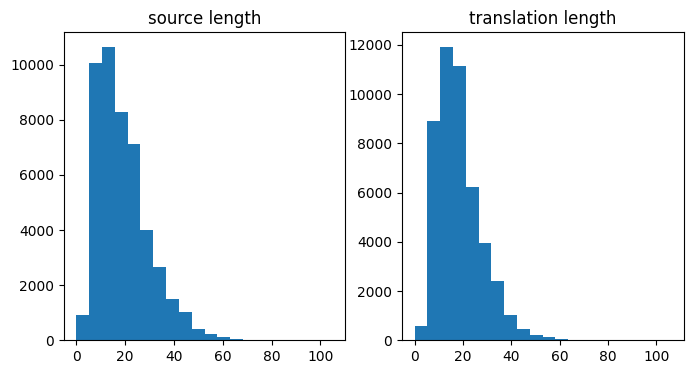

In [ ]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### Encoder-decoder model


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

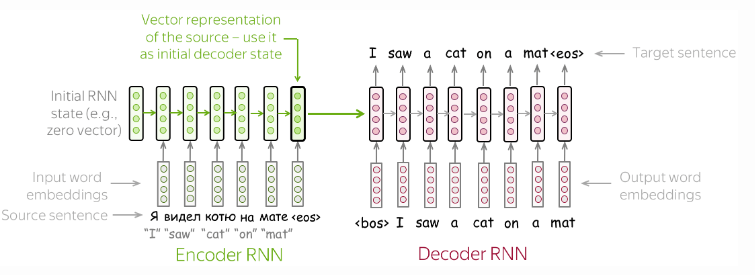

In [ ]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        # enc_seq: [batch, sequence length, hid_size], last_state: [batch, hid_size]

        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]
        prev_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state) # input & hidden states
        output_logits = self.logits(new_dec_state)

        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [ ]:
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [ ]:
train_inp[:3]

array(['этот отель находится в центре парижа , в 2 минутах от площади республики и станции метро с 5 лини@@ ями метро и 4 автобус@@ ными маршру@@ тами .',
       'на полностью оборудованной мини - кухне можно самостоятельно готовить .',
       'номера находятся под кры@@ шей или на ниж@@ них эта@@ жах с эр@@ ке@@ рами с видом на сад .'],
      dtype='<U524')

In [ ]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
transfer vincen@@ luna makar@@ taman quarter kat@@ tab@@ hid@@ cen@@ adi coastal stok iguaçu stok pian sibir@@ across hacienda ing exhibition chas@@ vann@@ onto pet
transfer vincen@@ raleigh alpen@@ ötz titude aust@@ wald exhibit@@ towers delhi ist blo@@ ist govern@@ bedroom barcelona pous@@ ši@@ sen cc@@ alaba@@ architect@@ mann ort
transfer vincen@@ raleigh alpen@@ ötz titude aust@@ wald exhibit@@ towers delhi ist blo@@ ist govern@@ bedroom barcelona pous@@ ši@@ sen cc@@ alaba@@ architect@@ mann ort


### Loss

Будем минимизировать categorical crossentropy во время обучения на данных $D$:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

$|D|$ - длина всех последовательностей, включая BOS and первые EOS токены, кроме PAD

In [ ]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return -logp_out[mask].mean()

In [ ]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.6102, device='cuda:0', grad_fn=<NegBackward0>)


### Оценка качества: BLEU

Распространенная метрика машинного перевода - [BLEU](https://en.wikipedia.org/wiki/BLEU). Эта метрика вычисляет долю верно предсказанных n-grams. В частности, например, для n=1, 2, 3, 4 она вычисляется как геометрическое среднее со штрафом за короткие переводы.

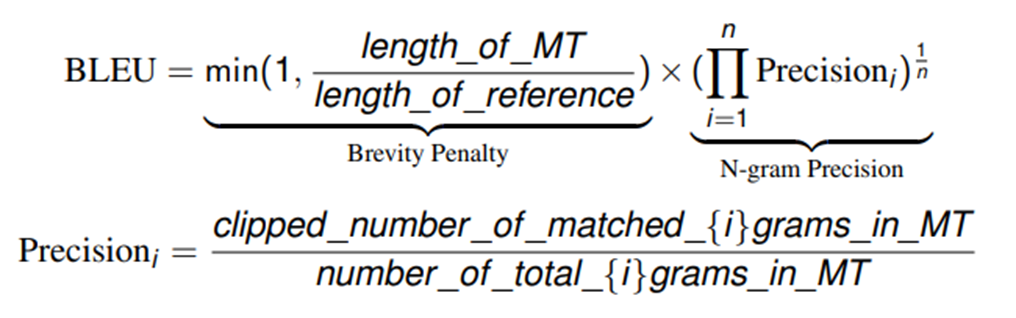

In [ ]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.0014713557439303593

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BasicModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

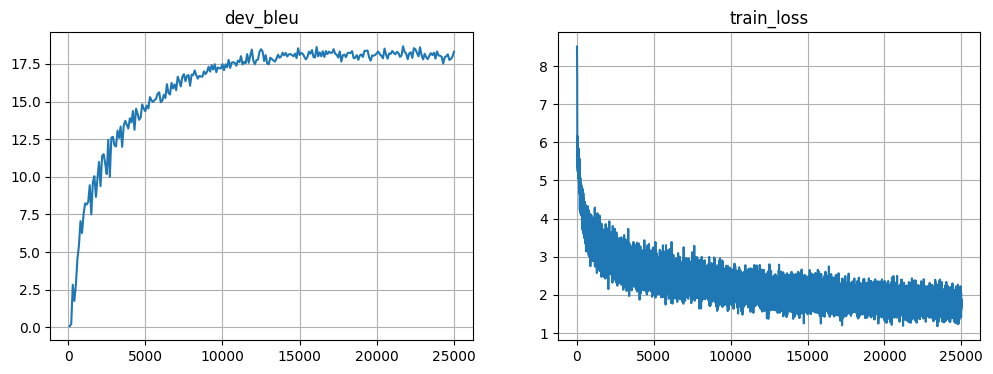

Mean loss=1.756


100%|██████████| 25000/25000 [18:22<00:00, 22.67it/s]


In [ ]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [ ]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в ванной комнате с ванной предоставляется фен .
the bathroom comes with a bathtub and a hairdryer .

на территории можно сыграть в дартс и сквош .
you will find a hot tub and a library .

апартаменты располагают гостиной зоной .
the apartment is equipped with a seating area .

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне .
guests can cook their meals in the fully equipped kitchen .

к услугам гостей 2 спальни и 1 ванная комната с ванной и / или душем , а также кухня с духовкой и микроволновой печью .
there is a double bedroom and a fully equipped kitchen with a dishwasher and a microwave .

ужин для гостей приготовят в ресторане ron@@ ni@@ e ' s w@@ ing@@ s & o@@ y@@ st@@ er bar .
savour german cuisine can be enjoyed at the golf@@ long day at the hotel ’ s restaurant , which offers interesting sports facilities .



In [ ]:
compute_bleu(model, dev_inp, dev_out)

18.305980597874896

### Attention

Добавим простой attention:

Имея последовательность $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ из encoder'а и decoder state $h^d$,

* Вычислим логиты двухслойной сеткой
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получим вероятности,
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвесим состояния encoder'а с вероятностями, чтобы получить **attention**
$$ attn = \sum_t p_t \cdot h^e_t $$

[Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/).

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units

        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        batch_size, ninp, enc_size = enc.shape

        # Compute logits
        x = self.linear_dec(dec).reshape(-1, 1, self.hid_size)
        x = torch.tanh(self.linear_enc(enc) + x)
        x = self.linear_out(x)

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        x[torch.where(inp_mask == False)] = -1e9

        # Compute attention probabilities (softmax)
        probs = self.softmax(x.reshape(batch_size, ninp))

        # Compute attention response using enc and probs
        attn = (probs.reshape(batch_size, ninp, 1) * enc).sum(1)

        return attn, probs

### Seq2seq model + attention

Теперь можно использовать слой attention в Seq2Seq модели:
![img](https://i.imgur.com/6fKHlHb.png)
_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

На каждом шагу используем предыдущее состояние декодера для подсчета attention, затем приконкатенируем attention ко входам следующего слоя. T


In [ ]:
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.enc0 = nn.LSTM(emb_size, hid_size, num_layers=2, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)

        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(hid_size, hid_size, attn_size)


    def encode(self, inp, **flags):
        """
        Takes input sequences, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        #[dec_start] = super().encode(inp, **flags)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        dec_start = self.dec_start(last_state)

        # apply attention layer from initial decoder hidden state
        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)

        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor

        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)

        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        return [new_dec_state, output_logits]


### Training loop - модель с Attention


In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [ ]:
model

AttentiveModel(
  (emb_inp): Embedding(8047, 64)
  (emb_out): Embedding(7800, 64)
  (enc0): LSTM(64, 128, num_layers=2, batch_first=True)
  (dec_start): Linear(in_features=128, out_features=128, bias=True)
  (dec0): GRUCell(192, 128)
  (logits): Linear(in_features=128, out_features=7800, bias=True)
  (attention): AttentionLayer(
    (linear_enc): Linear(in_features=128, out_features=128, bias=True)
    (linear_dec): Linear(in_features=128, out_features=128, bias=True)
    (linear_out): Linear(in_features=128, out_features=1, bias=True)
    (softmax): Softmax(dim=-1)
  )
)

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.0019216379246109212

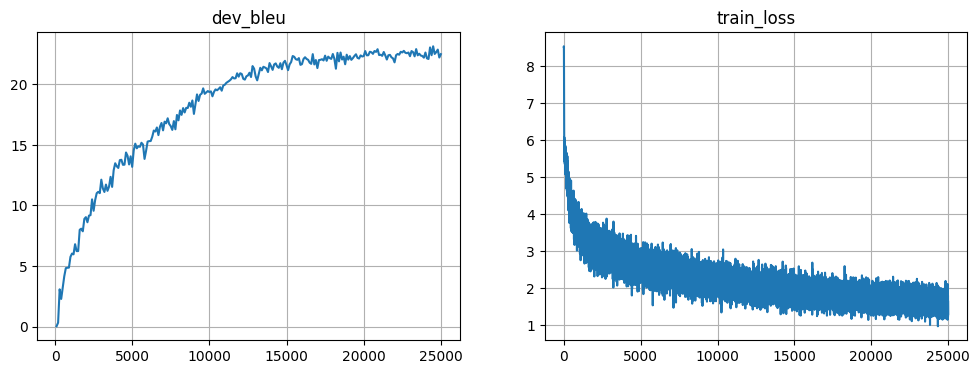

Mean loss=1.544


100%|██████████| 25000/25000 [49:33<00:00,  8.41it/s]


In [ ]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


In [ ]:
compute_bleu(model, dev_inp, dev_out)

22.50224262544424

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в ванной комнате с ванной предоставляется фен .
the bathroom comes with a hairdryer and a hairdryer .

на территории можно сыграть в дартс и сквош .
there is also a trampoline and table tennis .

апартаменты располагают гостиной зоной .
the apartment will provide you with a seating area .

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне .
guests can also enjoy a fully equipped kitchen , allowing self - catering apartment .

к услугам гостей 2 спальни и 1 ванная комната с ванной и / или душем , а также кухня с духовкой и микроволновой печью .
the upper floor has 2 bedrooms and a bathroom with a bath and a shower , bidet and a microwave .

ужин для гостей приготовят в ресторане ron@@ ni@@ e ' s w@@ ing@@ s & o@@ y@@ st@@ er bar .
at la maison son you will find a variety of drinks , roses .



## Что можно улучшить

* использовать различные RNN юниты: rnn/gru/lstm; более глубокие архитектуры
* Сделать encoder двунаправленным, попробовать различные attention (additive, dot-product, multi-head)
* word dropout, sheduling
* заменить greedy инференс на beam search
